✅ Đọc dữ liệu xong!
Real shape: (13995, 8), Simulate shape: (8725, 21)

📈 So sánh phân phối cột: eventname


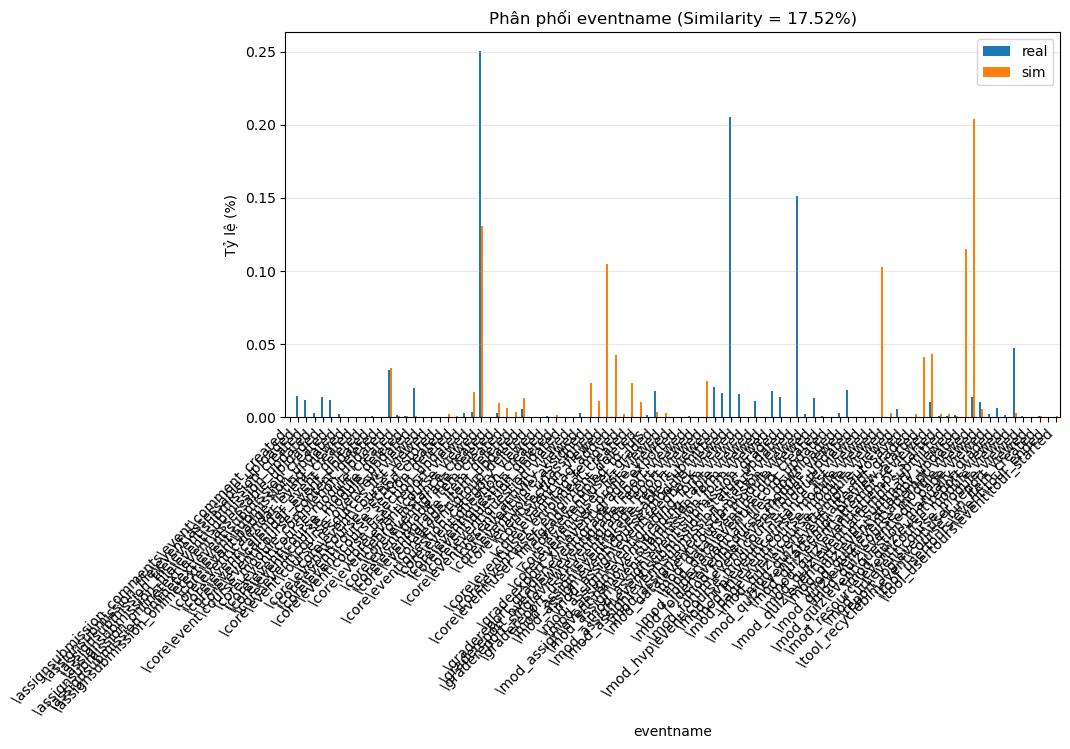


📈 So sánh phân phối cột: action


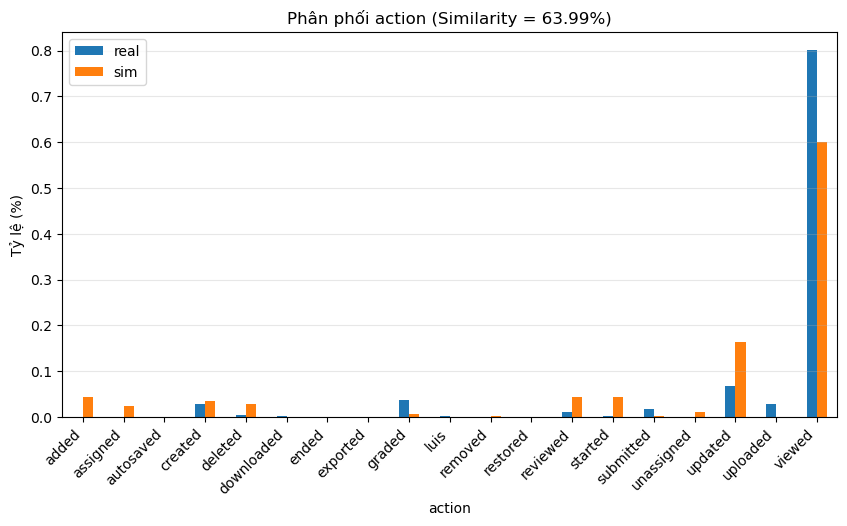


📈 So sánh phân phối cột: target


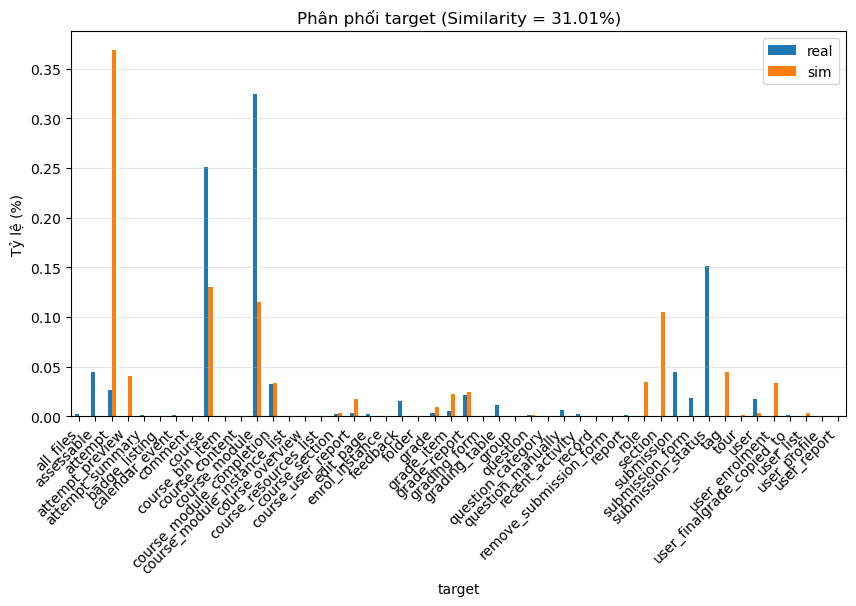


📈 So sánh phân phối cột: courseid


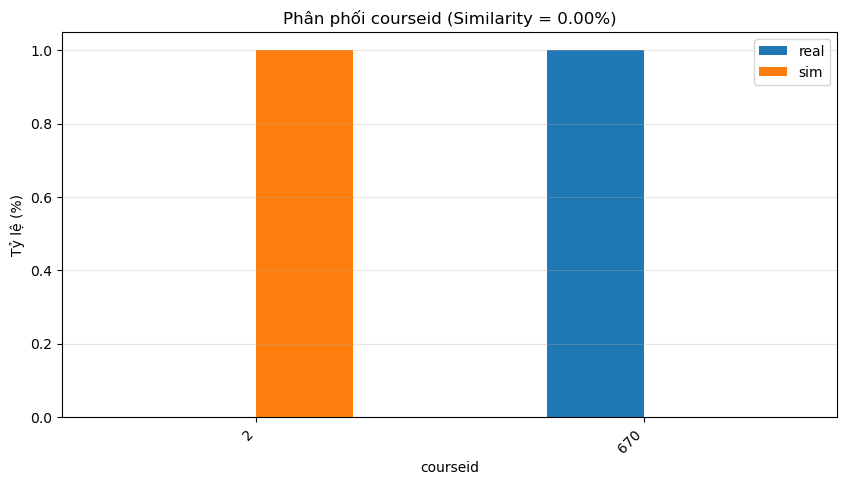


👥 So sánh phân phối số lượng log theo người dùng


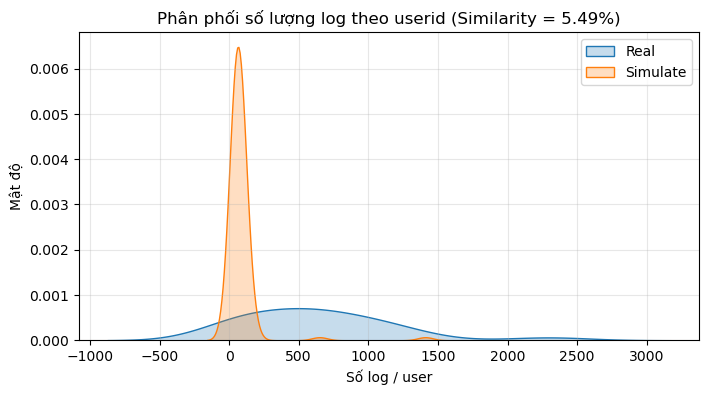

,Feature,JS_Divergence,Similarity (%),Đánh giá
0,eventname,0.8248,17.5182,⚠️ Kém
1,action,0.3601,63.9897,🟡 Trung bình
2,target,0.6899,31.0141,⚠️ Kém
3,courseid,1.0000,0.0000,NaN
4,userid_activity,0.9451,5.4903,⚠️ Kém


In [1]:
# 📊 So sánh phân phối giữa dataset Moodle gốc và dataset simulate JMeter
# ⚙️ Không xét đến yếu tố thời gian

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from IPython.display import display, HTML

# ------------------------------------------------------
# 1️⃣ Đọc dữ liệu
# ------------------------------------------------------
real_path = "../data/udk_moodle_log_course_670.csv"
sim_path  = "../jmeter_simulate/data_simulate_jmeter.csv"

real_df = pd.read_csv(real_path)
sim_df  = pd.read_csv(sim_path)

print("✅ Đọc dữ liệu xong!")
print(f"Real shape: {real_df.shape}, Simulate shape: {sim_df.shape}")

# ------------------------------------------------------
# 2️⃣ Tiền xử lý: chỉ giữ các cột quan trọng & thống nhất schema
# ------------------------------------------------------
real_df = real_df[['eventname', 'action', 'target', 'userid', 'courseid']].copy()
sim_df = sim_df[['eventname', 'action', 'target', 'userid', 'courseid']].copy()

# Chuẩn hóa kiểu dữ liệu
for df in [real_df, sim_df]:
    df['eventname'] = df['eventname'].astype(str).str.strip().str.lower()
    df['action'] = df['action'].astype(str).str.strip().str.lower()
    df['target'] = df['target'].astype(str).str.strip().str.lower()
    df['courseid'] = df['courseid'].astype(str)

# ------------------------------------------------------
# 3️⃣ Hàm so sánh phân phối & vẽ biểu đồ
# ------------------------------------------------------
def compare_distribution(col):
    print(f"\n📈 So sánh phân phối cột: {col}")

    real_vc = real_df[col].value_counts(normalize=True)
    sim_vc = sim_df[col].value_counts(normalize=True)

    all_keys = sorted(set(real_vc.index) | set(sim_vc.index))
    df_cmp = pd.DataFrame({
        "real": [real_vc.get(k, 0) for k in all_keys],
        "sim": [sim_vc.get(k, 0) for k in all_keys]
    }, index=all_keys)

    # Jensen–Shannon divergence
    js_div = jensenshannon(df_cmp["real"], df_cmp["sim"], base=2)
    similarity = (1 - js_div) * 100

    # Vẽ biểu đồ
    df_plot = df_cmp.copy()
    df_plot.plot(kind="bar", figsize=(10,5))
    plt.title(f"Phân phối {col} (Similarity = {similarity:.2f}%)")
    plt.xlabel(col)
    plt.ylabel("Tỷ lệ (%)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

    return js_div, similarity

# ------------------------------------------------------
# 4️⃣ Phân tích các phân phối danh mục
# ------------------------------------------------------
metrics = []
for col in ["eventname", "action", "target", "courseid"]:
    js, sim = compare_distribution(col)
    metrics.append((col, js, sim))

# ------------------------------------------------------
# 5️⃣ Phân phối theo người dùng
# ------------------------------------------------------
print("\n👥 So sánh phân phối số lượng log theo người dùng")

real_user = real_df['userid'].value_counts(normalize=True)
sim_user = sim_df['userid'].value_counts(normalize=True)
all_users = sorted(set(real_user.index) | set(sim_user.index))
df_user = pd.DataFrame({
    "real": [real_user.get(k, 0) for k in all_users],
    "sim": [sim_user.get(k, 0) for k in all_users]
})

js_user = jensenshannon(df_user["real"], df_user["sim"], base=2)
sim_user_score = (1 - js_user) * 100
metrics.append(("userid_activity", js_user, sim_user_score))

plt.figure(figsize=(8,4))
sns.kdeplot(real_df['userid'].value_counts(), label="Real", fill=True)
sns.kdeplot(sim_df['userid'].value_counts(), label="Simulate", fill=True)
plt.title(f"Phân phối số lượng log theo userid (Similarity = {sim_user_score:.2f}%)")
plt.xlabel("Số log / user")
plt.ylabel("Mật độ")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------
# 6️⃣ Tổng hợp kết quả
# ------------------------------------------------------
df_result = pd.DataFrame(metrics, columns=["Feature", "JS_Divergence", "Similarity (%)"])
df_result["Đánh giá"] = pd.cut(df_result["Similarity (%)"],
                               bins=[0,60,80,90,100],
                               labels=["⚠️ Kém", "🟡 Trung bình", "🟢 Tốt", "🟩 Rất tốt"])

display(HTML("<h3>📊 Tổng kết độ tương đồng giữa dataset gốc và simulate (JMeter)</h3>"))
display(df_result.round(4))
